In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

from ese.experiment.analysis.analyze_inf import load_cal_inference_stats
# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'fillNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'isNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notNA' for type <class 'pandas.core.series.Series'> is overriding 

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - '05_15_24_SpineWeb_SuppWAug'
        - '05_15_24_SW_FixedAugExp'
    
calibration:
    metric_cfg_file: "/storage/vbutoi/projects/ESE/ese/experiment/configs/inference/Calibration_Metrics.yaml"

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

In [3]:
aug_image_info_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 624000 -> 624000 rows.
Finished loading inference stats.
Log amounts: log.root                                                                                         log_set                                              
/storage/vbutoi/scratch/ESE/inference/05_15_24_SW_FixedAugExp/SpineWeb_Ensemble_Uncalibrated     20240515_133635-BOVN-26c59b48da2c1692e7d47114ae6d5381    42000
                                                                                                 20240515_133639-U3UD-3e3cf6d3f08860bba20b2b82dff6a1ad    42000
                                                                                                 20240515_133644-M54J-f983742f52dbaf6a710a429b536e1086    42000
                                                                                                 20240515_133649-UJN1-a99d4450a6067dd4c8be53e5926ce85a    42000
                                                                    

In [4]:
import ast

def support_augmentations(support_augs):
    # Join the tuple by ', '
    aug_list = list(ast.literal_eval(support_augs))
    if len(aug_list) == 0:
        return "None"
    else:
        return ', '.join(aug_list)

def exp_name(exp_root):
    return exp_root.split('/')[-1]

aug_image_info_df.augment(support_augmentations)
aug_image_info_df.augment(exp_name)

In [5]:
# We want to compare how Dice relates to ECE, this means we need to pivot our dataframe
aug_df_pivot = aug_image_info_df.pivot(index=['exp_name', 'data_id', 'sup_idx', 'support_augmentations'], columns='image_metric', values='metric_score').reset_index()

In [6]:
aug_df_pivot['support_augmentations'] = aug_df_pivot['support_augmentations'].astype('category')
aug_df_pivot['support_augmentations'] = aug_df_pivot['support_augmentations'].cat.reorder_categories([
    'None',
    'Affine',
    'Elastic',
    'HorizontalFlip',
    'Affine, Elastic',
    'Affine, HorizontalFlip',
    'Elastic, HorizontalFlip',
    'Affine, Elastic, HorizontalFlip'
])

Text(0.5, 1.0, 'Dice Score vs. Support Augmentations')

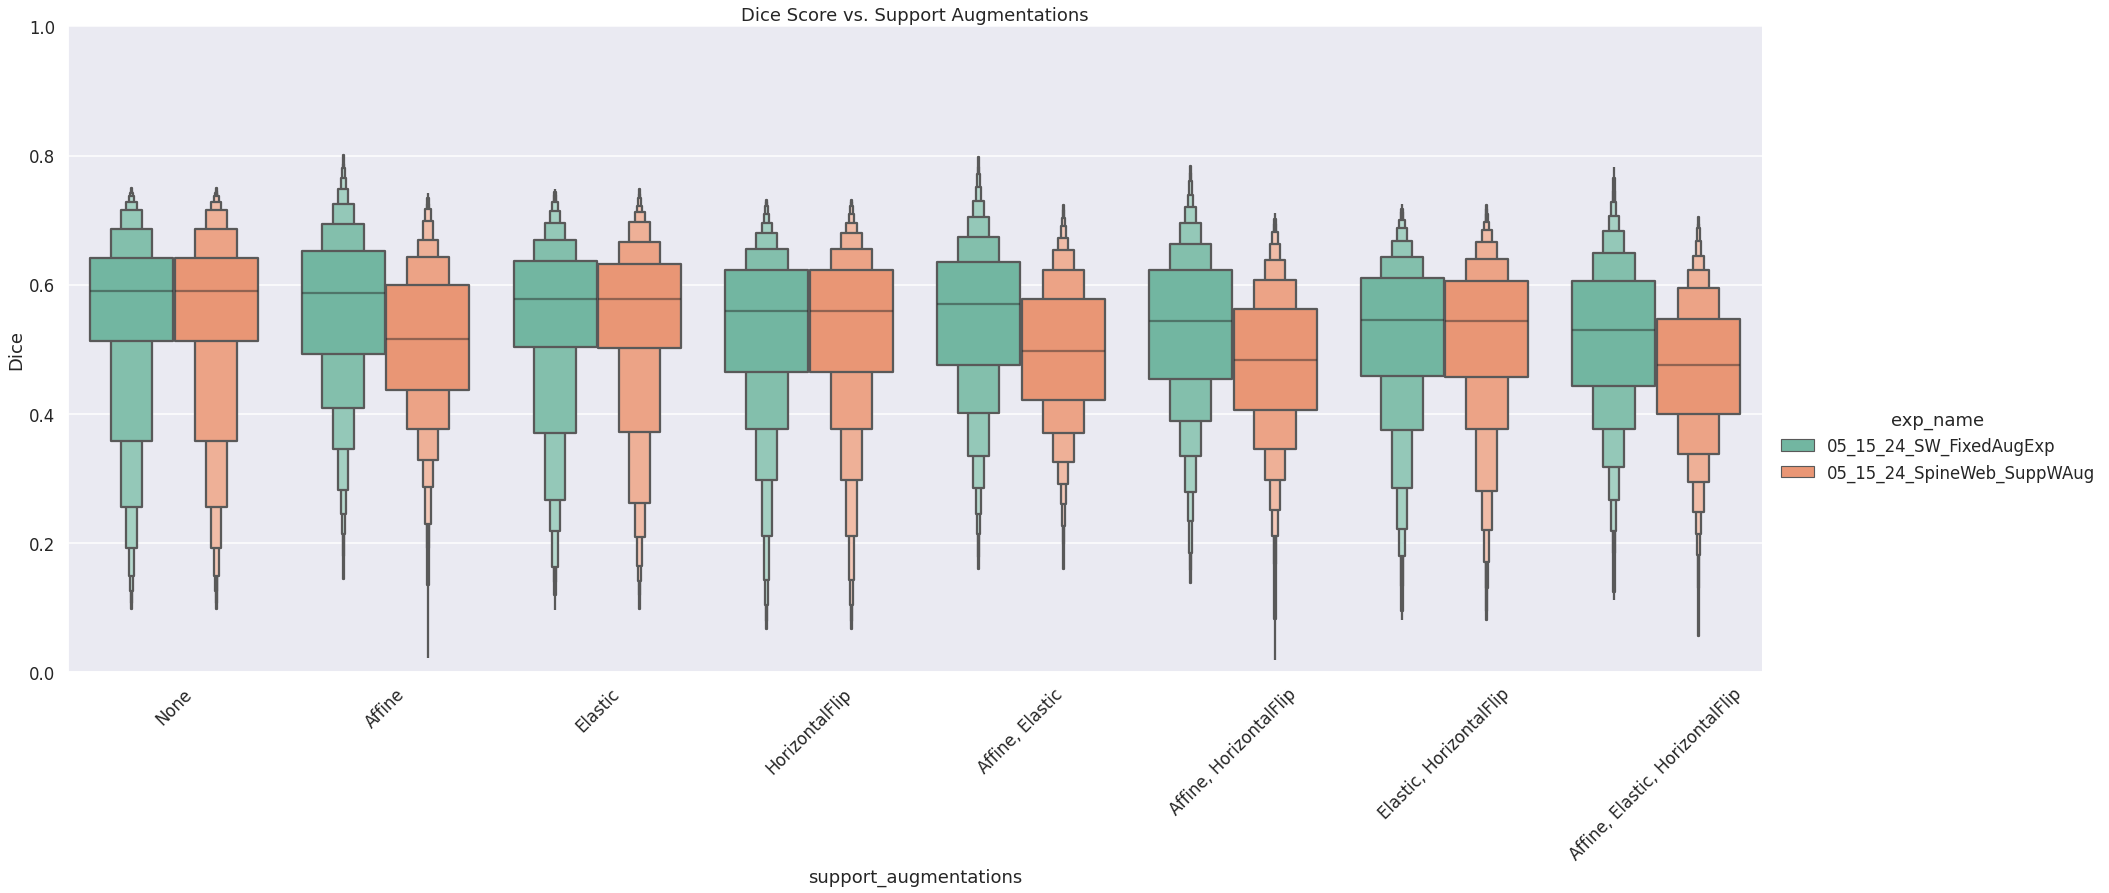

In [7]:
sns.catplot(
    data=aug_df_pivot,
    x='support_augmentations',
    y='Dice',
    hue='exp_name',
    kind='boxen',
    showfliers=False,
    aspect=2.5,
    height=10,
    palette='Set2',
)
# Rotate the x labels for better readability.
plt.xticks(rotation=45)
# Set the y axis to be between 0 and 1.
plt.ylim(0, 1)
# Set the title of the plot.
plt.title('Dice Score vs. Support Augmentations')

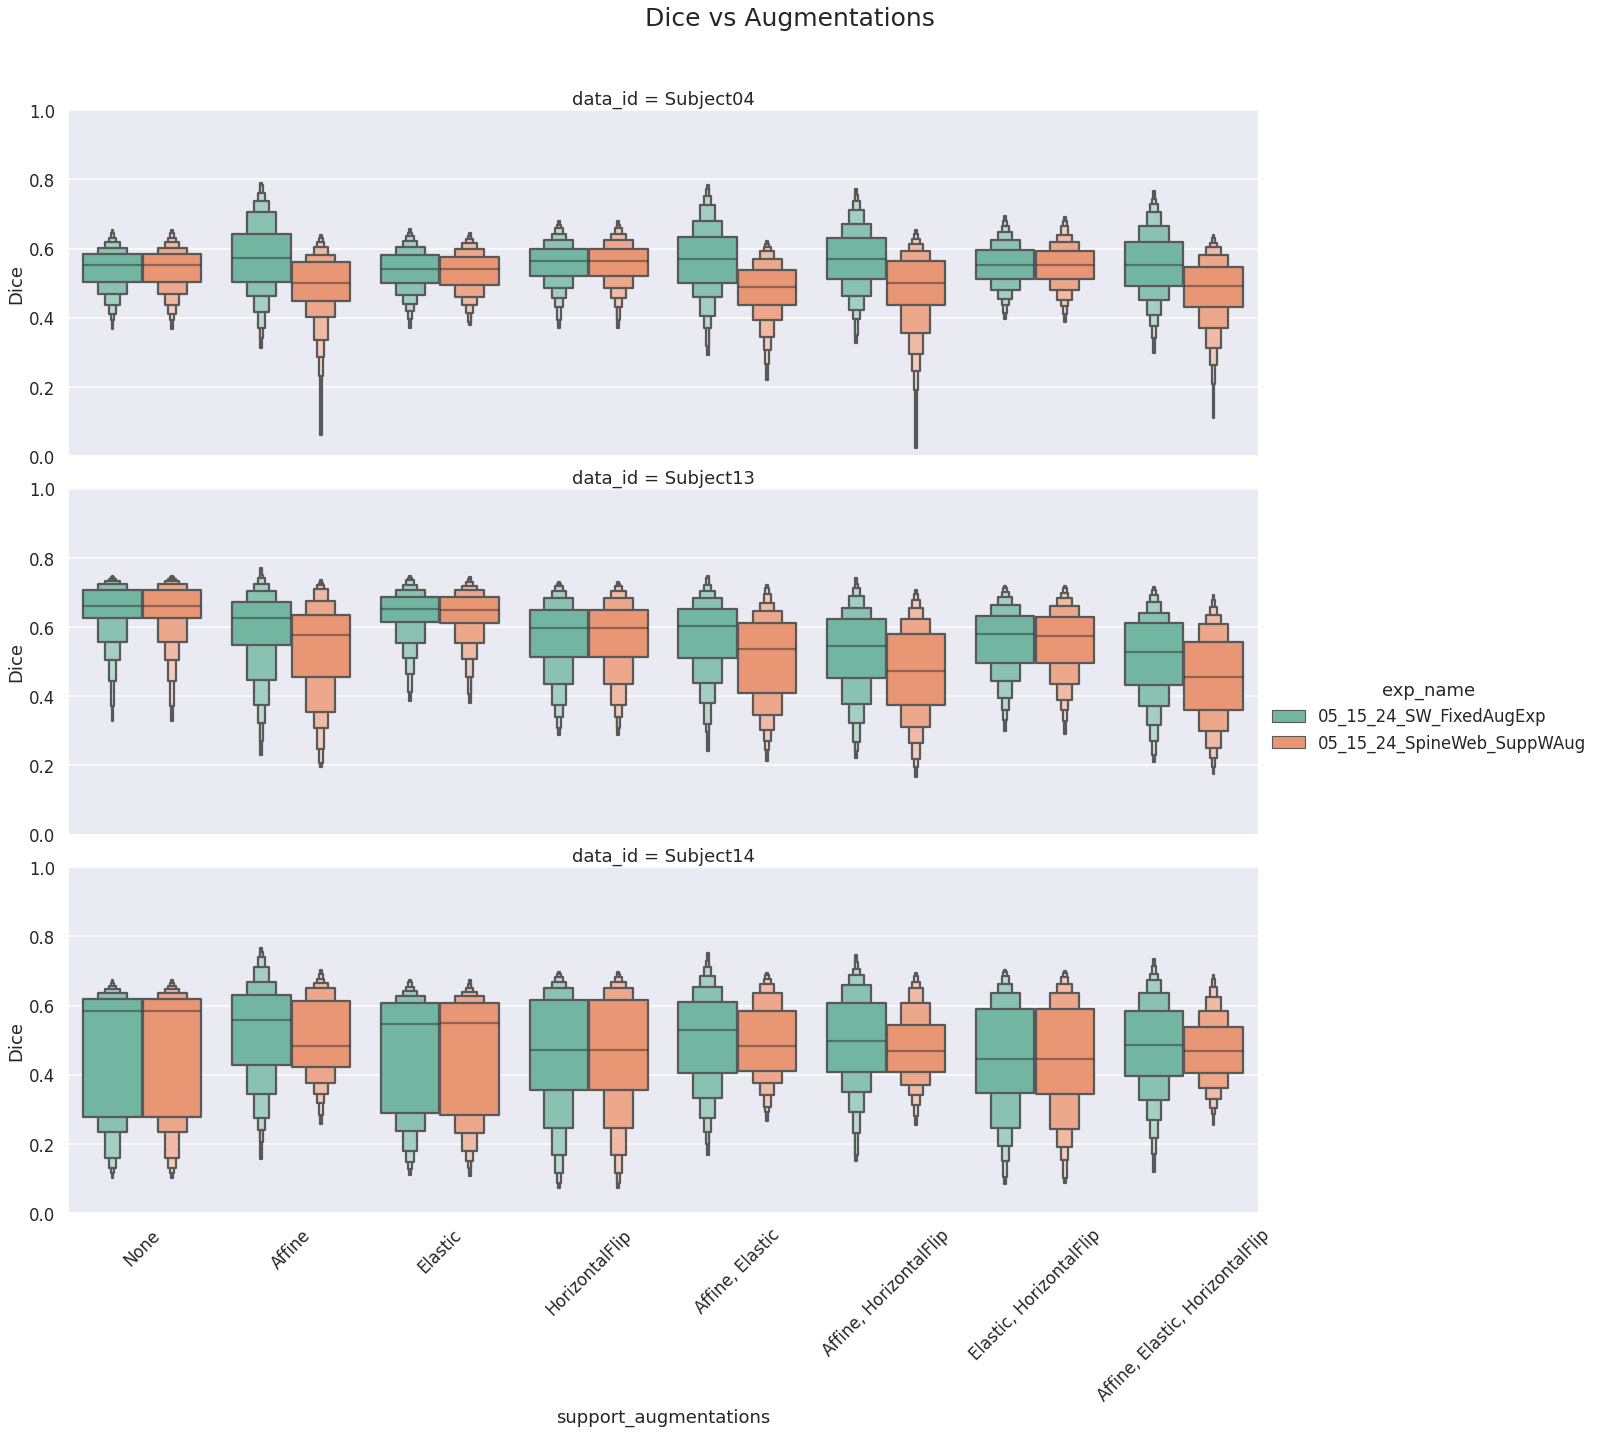

In [8]:
g = sns.catplot(
    data=aug_df_pivot.select(),
    x='support_augmentations',
    y='Dice',
    hue='exp_name',
    kind='boxen',
    row='data_id',
    showfliers=False,
    aspect=3,
    height=6,
    palette='Set2',
)
# Set the y axis to be between 0 and 1.
g.set(ylim=(0, 1))
# Rotate the x labels for better readability.
plt.xticks(rotation=45)
# Set the title for the collection of subplots.
g.fig.suptitle("Dice vs Augmentations", fontsize=25)
g.fig.subplots_adjust(top=0.9)